In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [30]:
# data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
# # data['isCancerous'] = data['isCancerous'].astype(str)
# # data['cellType'] = data['cellType'].astype(str)
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [31]:
# class_samples_isCancerous = train_data['isCancerous'].value_counts()
# total_samples = np.sum(class_samples_isCancerous)
# class_weights_isCancerous = total_samples / class_samples_isCancerous
# class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}
#
# class_samples_cellType = train_data['cellType'].value_counts()
# total_samples = np.sum(class_samples_cellType)
# class_weights_cellType = total_samples / class_samples_cellType
# class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [32]:
# batch_size = 32
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )
#
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255
# )
# test_data['cellType'] = test_data['cellType'].astype(str)
# validation_cellType_generator = test_datagen.flow_from_dataframe(
#     test_data,
#     directory='./Image_classification_data/patch_images',
#     x_col='ImageName',
#     y_col='cellType',
#     target_size=(27, 27),
#     batch_size=batch_size,
#     class_mode='categorical')

In [33]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01

model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [34]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
# data['isCancerous'] = data['isCancerous'].astype(str)
# data['cellType'] = data['cellType'].astype(str)
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [35]:
model_categorical = tf.keras.models.load_model('saved_model/model_categorical')
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['cellType'] = np.nan
data_extra.loc[data_extra['isCancerous'] == 1, 'cellType'] = 2
data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
data_extra_labeled = data_extra[data_extra['cellType'] == 2]
data = pd.concat([data, data_extra_labeled], axis=0).reset_index(drop=True)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 [Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0'),
  Text(2.5, 0, '2.5'),
  Text(3.0, 0, '3.0'),
  Text(3.5, 0, '3.5')])

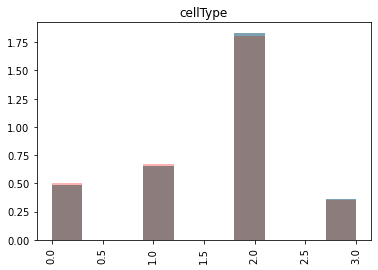

In [36]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [37]:
# 计算isCancerous(二分类)的比例
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

# cellType(多分类)的比例
class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)
train_data['cellType'] = train_data['cellType'].astype(str)

/var/folders/qx/28c_j79n3zn_3rkwzsdcmn240000gn/T/ipykernel_4011/370272220.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)


In [38]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 2578 validated image filenames belonging to 4 classes.


In [39]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    data_extra_unlabeled,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 10308 validated image filenames belonging to 4 classes.
Found 7394 validated image filenames belonging to 1 classes.


In [40]:
consistency_weight = 1
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-08)

# 定义数据增强策略
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomContrast(factor=(0.8, 1.2)),
    tf.keras.layers.RandomBrightness(factor=0.1),
])

# 训练循环
def apply_uda(x_batch, y_batch, x_unlabeled, model, optimizer, training=True, class_weight_dict=None):
    x_unlabeled_augmented = None
    if x_unlabeled is not None:
        # 对无标签数据进行数据增强
        x_unlabeled_augmented = data_augmentation(x_unlabeled)

    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x_batch)
        if x_unlabeled is not None:
            y_pred_unlabeled = model(x_unlabeled)
            y_pred_unlabeled_augmented = model(x_unlabeled_augmented)

        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            sample_weights = tf.gather(class_weight_dict, tf.argmax(y_batch, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled))

        # 如果提供了无标签数据，则计算一致性损失，(半监督学习)
        if x_unlabeled is not None:
            consistency_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_pred_unlabeled, y_pred_unlabeled_augmented))
            total_loss = supervised_loss + consistency_weight * consistency_loss
        else:
            total_loss = supervised_loss

        # 计算准确度
        accuracy = tf.keras.metrics.categorical_accuracy(y_batch, y_pred_labeled)

    if training:
        # 反向传播和优化
        grads = tape.gradient(total_loss, model_categorical.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))
    return total_loss, supervised_loss, consistency_loss if x_unlabeled is not None else None, accuracy

epochs = 20

min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = optimizer.learning_rate.numpy()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    steps = 0

    with tqdm(total=round(len(train_data) / batch_size), desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled, _) in zip(train_generator, unlabeled_generator):
            progress_bar.update(1)
            loss, supervised_loss, consistency_loss, accuracy = apply_uda(x_batch, y_batch, x_unlabeled, model_categorical, optimizer, class_weight_dict_cellType)
            total_loss += loss
            total_supervised_loss += supervised_loss
            total_consistency_loss += consistency_loss
            total_accuracy += tf.reduce_mean(accuracy)
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        loss, _, _, accuracy = apply_uda(x_batch, y_batch, None, model_categorical, optimizer, False)
        total_loss += loss
        total_accuracy += tf.reduce_mean(accuracy)
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps
    history["val_loss"].append(avg_loss.numpy())
    history["val_accuracy"].append(avg_accuracy.numpy())
    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, learning rate: {current_learning_rate}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1

    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        optimizer.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0



Epoch 1/20


Training: 323it [00:41,  7.87it/s]                                                                  


 - loss: 0.6526, supervised_loss: 0.3497, consistency_loss: 0.3029, accuracy: 0.8758
Validation set： - loss: 0.3429, accuracy: 0.8741, learning rate: 9.99999993922529e-09
Epoch 2/20


Training: 323it [00:40,  8.00it/s]                                                                  


 - loss: 0.6412, supervised_loss: 0.3451, consistency_loss: 0.2961, accuracy: 0.8738
Validation set： - loss: 0.3419, accuracy: 0.8744, learning rate: 9.99999993922529e-09
Epoch 3/20


Training: 323it [00:40,  7.98it/s]                                                                  


 - loss: 0.6348, supervised_loss: 0.3518, consistency_loss: 0.2830, accuracy: 0.8745
Validation set： - loss: 0.3415, accuracy: 0.8746, learning rate: 9.99999993922529e-09
Epoch 4/20


Training: 323it [00:40,  7.96it/s]                                                                  


 - loss: 0.6091, supervised_loss: 0.3476, consistency_loss: 0.2615, accuracy: 0.8726
Validation set： - loss: 0.3389, accuracy: 0.8762, learning rate: 9.99999993922529e-09
Epoch 5/20


Training: 323it [00:40,  8.01it/s]                                                                  


 - loss: 0.5838, supervised_loss: 0.3465, consistency_loss: 0.2372, accuracy: 0.8730
Validation set： - loss: 0.3382, accuracy: 0.8765, learning rate: 9.99999993922529e-09
Epoch 6/20


Training: 323it [00:39,  8.16it/s]                                                                  


 - loss: 0.5603, supervised_loss: 0.3392, consistency_loss: 0.2211, accuracy: 0.8786
Validation set： - loss: 0.3388, accuracy: 0.8756, learning rate: 9.99999993922529e-09
Epoch 7/20


Training: 323it [00:39,  8.09it/s]                                                                  


 - loss: 0.5579, supervised_loss: 0.3394, consistency_loss: 0.2185, accuracy: 0.8778
Validation set： - loss: 0.3385, accuracy: 0.8750, learning rate: 9.99999993922529e-09
Epoch 8/20


Training: 323it [00:40,  7.96it/s]                                                                  


 - loss: 0.5546, supervised_loss: 0.3381, consistency_loss: 0.2165, accuracy: 0.8810
Validation set： - loss: 0.3384, accuracy: 0.8756, learning rate: 3.162277640949729e-09
Epoch 9/20


Training: 323it [00:40,  7.98it/s]                                                                  


 - loss: 0.5490, supervised_loss: 0.3355, consistency_loss: 0.2136, accuracy: 0.8792
Validation set： - loss: 0.3403, accuracy: 0.8750, learning rate: 3.162277640949729e-09
Epoch 10/20


Training: 323it [00:40,  7.97it/s]                                                                  


 - loss: 0.5561, supervised_loss: 0.3408, consistency_loss: 0.2153, accuracy: 0.8746
Validation set： - loss: 0.3374, accuracy: 0.8763, learning rate: 3.162277640949729e-09
Epoch 11/20


Training: 323it [00:40,  7.98it/s]                                                                  


 - loss: 0.5615, supervised_loss: 0.3465, consistency_loss: 0.2151, accuracy: 0.8717
Validation set： - loss: 0.3392, accuracy: 0.8757, learning rate: 9.999999939225292e-10
Epoch 12/20


Training: 323it [00:40,  7.96it/s]                                                                  


 - loss: 0.5551, supervised_loss: 0.3418, consistency_loss: 0.2133, accuracy: 0.8761
Validation set： - loss: 0.3384, accuracy: 0.8757, learning rate: 9.999999939225292e-10
Epoch 13/20


Training: 323it [00:39,  8.18it/s]                                                                  


 - loss: 0.5526, supervised_loss: 0.3378, consistency_loss: 0.2148, accuracy: 0.8796
Validation set： - loss: 0.3381, accuracy: 0.8760, learning rate: 9.999999939225292e-10
Epoch 14/20


Training: 323it [00:39,  8.13it/s]                                                                  


 - loss: 0.5565, supervised_loss: 0.3409, consistency_loss: 0.2156, accuracy: 0.8780
Validation set： - loss: 0.3375, accuracy: 0.8763, learning rate: 3.1622776409497293e-10
Epoch 15/20


Training: 323it [00:40,  8.01it/s]                                                                  


 - loss: 0.5540, supervised_loss: 0.3399, consistency_loss: 0.2141, accuracy: 0.8755
Validation set： - loss: 0.3396, accuracy: 0.8760, learning rate: 3.1622776409497293e-10
Epoch 16/20


Training: 323it [00:40,  8.03it/s]                                                                  


 - loss: 0.5573, supervised_loss: 0.3460, consistency_loss: 0.2114, accuracy: 0.8723
Validation set： - loss: 0.3381, accuracy: 0.8763, learning rate: 3.1622776409497293e-10
Epoch 17/20


Training: 323it [00:40,  7.94it/s]                                                                  


 - loss: 0.5551, supervised_loss: 0.3394, consistency_loss: 0.2157, accuracy: 0.8773
Validation set： - loss: 0.3390, accuracy: 0.8757, learning rate: 9.999999939225292e-11
Epoch 18/20


Training: 323it [00:40,  8.01it/s]                                                                  


 - loss: 0.5539, supervised_loss: 0.3400, consistency_loss: 0.2138, accuracy: 0.8790
Validation set： - loss: 0.3375, accuracy: 0.8766, learning rate: 9.999999939225292e-11
Epoch 19/20


Training: 323it [00:40,  7.95it/s]                                                                  


 - loss: 0.5645, supervised_loss: 0.3495, consistency_loss: 0.2150, accuracy: 0.8743
Validation set： - loss: 0.3369, accuracy: 0.8766, learning rate: 9.999999939225292e-11
Epoch 20/20


Training: 323it [00:41,  7.74it/s]                                                                  


 - loss: 0.5524, supervised_loss: 0.3380, consistency_loss: 0.2144, accuracy: 0.8777
Validation set： - loss: 0.3386, accuracy: 0.8763, learning rate: 3.162277640949729e-11


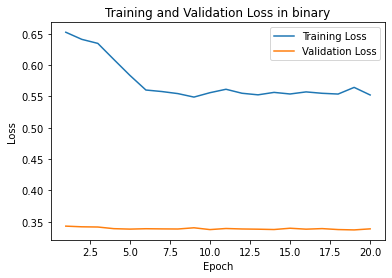

In [41]:
train_loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

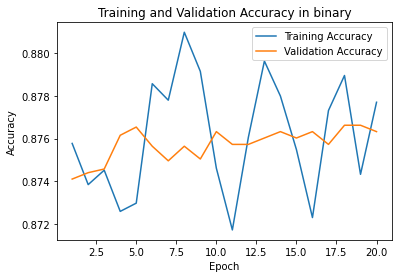

In [42]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()